In [1]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-01-13 13:39:05.421237: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 13:39:05.452412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 13:39:05.452438: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 13:39:05.452455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 13:39:05.458347: I tensorflow/core/platform/cpu_feature_g

# netCDF Data Control

In [2]:
def load_conc_map(data, sp):
    conc_map = np.zeros((24, 1, 82, 67))
    for key in sp: 
        conc_map += data.variables[key][...]
    return conc_map

hourly_sample = Dataset('/home/user/workdir/main/datasets/nc/RSM_1/CCTM_GUIDE_RSM_Linux2_x86_64mpif90.GUIDE.RSM.ACONC.2012357.ncf', 'r')

sulf = ['ASO4J', 'ASO4I', 'ASO4K']
conc_maps = load_conc_map(hourly_sample, sulf)
# conc_maps[0].shape            # (1, 82, 67)
# conc_maps[0].squeeze().shape  # (82, 67)

In [3]:
for time in range(0, len(conc_maps)):
    sulf_data = conc_maps[time].squeeze()
    plt.figure(figsize=(12, 5))
    plt.imshow(sulf_data, origin="lower", cmap='jet')
    plt.colorbar(label="Sulfate Concentration")
    plt.title(f"Sulfate Distribution at {time} hours")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    plt.savefig(f'/mnt/dsk1/mrlee/result/sulfate/sulf_{str(time).zfill(4)}.png', bbox_inches='tight')
    plt.close('all')

    print(f'{time+1}/{24}', end='\r')

In [4]:
def create_gif(image_folder, output_gif, resize=True, duration=500):
    images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]
    images.sort()
    if not images:
        return
    opened_images = [Image.open(img) for img in images]
    sizes = [img.size for img in opened_images]
    # print("이미지 크기 목록:", sizes)

    if len(set(sizes)) == 1:
        opened_images[0].save(output_gif, save_all=True, append_images=opened_images[1:], duration=duration, loop=0)
    else:
        min_size = (min([w for w, h in sizes]), min([h for w, h in sizes]))
        resized_images = [img.resize(min_size, Image.Resampling.LANCZOS) for img in opened_images]
        resized_images[0].save(output_gif, save_all=True, append_images=resized_images[1:], duration=duration, loop=0)

image_folder = '/mnt/dsk1/mrlee/result/sulfate' # PNG 이미지가 저장된 경로
output_gif = '/mnt/dsk1/mrlee/result/sulfate/sulfate_output.gif' # 생성될 GIF 경로
create_gif(image_folder, output_gif)

# Training (Sulfate)

In [5]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Sulfate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [6]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/sulfate/2019data/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.3  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
# define callback
def scheduler(epoch, lr):
    if epoch < 400: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/sulfate/2019data/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-13 11:16:46.397876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21030 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-13 11:16:46.399530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22082 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-13 11:16:46.400994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22082 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-13 11:16:46.402476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21958 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-13 11:17:12.793749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:17:12.812646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:17:12.839535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:17:12.872068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:17:15.593204: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9d68aed0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 11:17:15.593251: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 11:17:15.593265: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 11:17:15.59327

3/3 [==============================] - ETA: 0s - loss: 5.4053  INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-01-7.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-01-7.74/assets


3/3 [==============================] - 45s 7s/step - loss: 5.4053 - val_loss: 7.7438 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 4.1859INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-02-7.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-02-7.67/assets


3/3 [==============================] - 9s 5s/step - loss: 4.1859 - val_loss: 7.6656 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 3.0996INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-03-7.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-03-7.52/assets


3/3 [==============================] - 9s 4s/step - loss: 3.0996 - val_loss: 7.5176 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 2.2094INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-04-7.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-04-7.31/assets


3/3 [==============================] - 9s 4s/step - loss: 2.2094 - val_loss: 7.3051 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 1.7618INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-05-7.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-05-7.03/assets


3/3 [==============================] - 9s 5s/step - loss: 1.7618 - val_loss: 7.0325 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 1.5461INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-06-6.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-06-6.72/assets


3/3 [==============================] - 10s 5s/step - loss: 1.5461 - val_loss: 6.7234 - lr: 0.0010
Epoch 7/500
2/3 [===================>..........] - ETA: 0s - loss: 1.4196INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-07-6.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-07-6.41/assets


3/3 [==============================] - 9s 5s/step - loss: 1.4044 - val_loss: 6.4097 - lr: 0.0010
Epoch 8/500
2/3 [===================>..........] - ETA: 0s - loss: 1.2982INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-08-6.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-08-6.11/assets


3/3 [==============================] - 9s 5s/step - loss: 1.2856 - val_loss: 6.1142 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - ETA: 0s - loss: 1.1757INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-09-5.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-09-5.85/assets


3/3 [==============================] - 9s 5s/step - loss: 1.1757 - val_loss: 5.8516 - lr: 0.0010
Epoch 10/500
3/3 [==============================] - ETA: 0s - loss: 1.0724INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-10-5.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-10-5.63/assets


3/3 [==============================] - 9s 5s/step - loss: 1.0724 - val_loss: 5.6285 - lr: 0.0010
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 0.9747INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-11-5.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-11-5.44/assets


3/3 [==============================] - 9s 5s/step - loss: 0.9747 - val_loss: 5.4436 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - ETA: 0s - loss: 0.8847INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-12-5.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-12-5.29/assets


3/3 [==============================] - 9s 5s/step - loss: 0.8847 - val_loss: 5.2932 - lr: 0.0010
Epoch 13/500
3/3 [==============================] - ETA: 0s - loss: 0.8035INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-13-5.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-13-5.16/assets


3/3 [==============================] - 9s 5s/step - loss: 0.8035 - val_loss: 5.1623 - lr: 0.0010
Epoch 14/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7391INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-14-5.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-14-5.04/assets


3/3 [==============================] - 9s 5s/step - loss: 0.7315 - val_loss: 5.0386 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - ETA: 0s - loss: 0.6699INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-15-4.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-15-4.92/assets


3/3 [==============================] - 9s 5s/step - loss: 0.6699 - val_loss: 4.9158 - lr: 0.0010
Epoch 16/500
3/3 [==============================] - ETA: 0s - loss: 0.6147INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-16-4.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-16-4.79/assets


3/3 [==============================] - 10s 5s/step - loss: 0.6147 - val_loss: 4.7884 - lr: 0.0010
Epoch 17/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5692INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-17-4.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-17-4.66/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5644 - val_loss: 4.6612 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - ETA: 0s - loss: 0.5196INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-18-4.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-18-4.53/assets


3/3 [==============================] - 11s 5s/step - loss: 0.5196 - val_loss: 4.5348 - lr: 0.0010
Epoch 19/500
3/3 [==============================] - ETA: 0s - loss: 0.4786INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-19-4.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-19-4.41/assets


3/3 [==============================] - 10s 5s/step - loss: 0.4786 - val_loss: 4.4119 - lr: 0.0010
Epoch 20/500
2/3 [===================>..........] - ETA: 0s - loss: 0.4454INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-20-4.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-20-4.28/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4415 - val_loss: 4.2816 - lr: 0.0010
Epoch 21/500
3/3 [==============================] - ETA: 0s - loss: 0.4074INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-21-4.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-21-4.16/assets


3/3 [==============================] - 11s 5s/step - loss: 0.4074 - val_loss: 4.1587 - lr: 0.0010
Epoch 22/500
3/3 [==============================] - ETA: 0s - loss: 0.3759INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-22-4.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-22-4.05/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3759 - val_loss: 4.0465 - lr: 0.0010
Epoch 23/500
3/3 [==============================] - ETA: 0s - loss: 0.3462INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-23-3.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-23-3.93/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3462 - val_loss: 3.9264 - lr: 0.0010
Epoch 24/500
3/3 [==============================] - ETA: 0s - loss: 0.3193INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-24-3.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-24-3.82/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3193 - val_loss: 3.8230 - lr: 0.0010
Epoch 25/500
3/3 [==============================] - ETA: 0s - loss: 0.2949INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-25-3.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-25-3.72/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2949 - val_loss: 3.7220 - lr: 0.0010
Epoch 26/500
3/3 [==============================] - ETA: 0s - loss: 0.2722INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-26-3.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-26-3.61/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2722 - val_loss: 3.6105 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 0.2512INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-27-3.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-27-3.50/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2512 - val_loss: 3.5046 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - ETA: 0s - loss: 0.2330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-28-3.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-28-3.40/assets


3/3 [==============================] - 11s 5s/step - loss: 0.2330 - val_loss: 3.4043 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - ETA: 0s - loss: 0.2151INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-29-3.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-29-3.31/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2151 - val_loss: 3.3068 - lr: 0.0010
Epoch 30/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2018INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-30-3.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-30-3.22/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2001 - val_loss: 3.2192 - lr: 0.0010
Epoch 31/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1863INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-31-3.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-31-3.13/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1846 - val_loss: 3.1274 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - ETA: 0s - loss: 0.1708INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-32-3.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-32-3.04/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1708 - val_loss: 3.0391 - lr: 0.0010
Epoch 33/500
3/3 [==============================] - ETA: 0s - loss: 0.1593INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-33-2.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-33-2.95/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1593 - val_loss: 2.9495 - lr: 0.0010
Epoch 34/500
3/3 [==============================] - ETA: 0s - loss: 0.1484INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-34-2.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-34-2.86/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1484 - val_loss: 2.8607 - lr: 0.0010
Epoch 35/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1394INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-35-2.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-35-2.76/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1386 - val_loss: 2.7644 - lr: 0.0010
Epoch 36/500
3/3 [==============================] - ETA: 0s - loss: 0.1290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-36-2.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-36-2.68/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1290 - val_loss: 2.6776 - lr: 0.0010
Epoch 37/500
3/3 [==============================] - ETA: 0s - loss: 0.1203INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-37-2.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-37-2.59/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1203 - val_loss: 2.5938 - lr: 0.0010
Epoch 38/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1137INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-38-2.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-38-2.51/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1128 - val_loss: 2.5127 - lr: 0.0010
Epoch 39/500
3/3 [==============================] - ETA: 0s - loss: 0.1058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-39-2.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-39-2.44/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1058 - val_loss: 2.4370 - lr: 0.0010
Epoch 40/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1004INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-40-2.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-40-2.35/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0996 - val_loss: 2.3545 - lr: 0.0010
Epoch 41/500
3/3 [==============================] - ETA: 0s - loss: 0.0935INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-41-2.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-41-2.28/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0935 - val_loss: 2.2842 - lr: 0.0010
Epoch 42/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0891INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-42-2.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-42-2.21/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0886 - val_loss: 2.2084 - lr: 0.0010
Epoch 43/500
3/3 [==============================] - ETA: 0s - loss: 0.0841INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-43-2.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-43-2.15/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0841 - val_loss: 2.1518 - lr: 0.0010
Epoch 44/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0797INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-44-2.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-44-2.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0792 - val_loss: 2.0871 - lr: 0.0010
Epoch 45/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0758INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-45-2.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-45-2.03/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0752 - val_loss: 2.0261 - lr: 0.0010
Epoch 46/500
3/3 [==============================] - ETA: 0s - loss: 0.0723INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-46-1.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-46-1.98/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0723 - val_loss: 1.9775 - lr: 0.0010
Epoch 47/500
3/3 [==============================] - ETA: 0s - loss: 0.0700INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-47-1.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-47-1.91/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0700 - val_loss: 1.9059 - lr: 0.0010
Epoch 48/500
3/3 [==============================] - ETA: 0s - loss: 0.0657INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-48-1.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-48-1.85/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0657 - val_loss: 1.8504 - lr: 0.0010
Epoch 49/500
3/3 [==============================] - ETA: 0s - loss: 0.0639INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-49-1.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-49-1.80/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0639 - val_loss: 1.8030 - lr: 0.0010
Epoch 50/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0612INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-50-1.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-50-1.76/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0609 - val_loss: 1.7627 - lr: 0.0010
Epoch 51/500
3/3 [==============================] - ETA: 0s - loss: 0.0586INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-51-1.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-51-1.72/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0586 - val_loss: 1.7167 - lr: 0.0010
Epoch 52/500
3/3 [==============================] - ETA: 0s - loss: 0.0561INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-52-1.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-52-1.67/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0561 - val_loss: 1.6679 - lr: 0.0010
Epoch 53/500
3/3 [==============================] - ETA: 0s - loss: 0.0540INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-53-1.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-53-1.62/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0540 - val_loss: 1.6172 - lr: 0.0010
Epoch 54/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0525INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-54-1.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-54-1.56/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0525 - val_loss: 1.5649 - lr: 0.0010
Epoch 55/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0507INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-55-1.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-55-1.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0505 - val_loss: 1.5241 - lr: 0.0010
Epoch 56/500
3/3 [==============================] - ETA: 0s - loss: 0.0490INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-56-1.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-56-1.49/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0490 - val_loss: 1.4856 - lr: 0.0010
Epoch 57/500
3/3 [==============================] - ETA: 0s - loss: 0.0478INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-57-1.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-57-1.45/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0478 - val_loss: 1.4508 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 0.0463INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-58-1.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-58-1.41/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0463 - val_loss: 1.4115 - lr: 0.0010
Epoch 59/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0455INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-59-1.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-59-1.38/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0453 - val_loss: 1.3808 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 0.0440INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-60-1.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-60-1.34/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0440 - val_loss: 1.3443 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 0.0430INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-61-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-61-1.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0430 - val_loss: 1.3116 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 0.0420INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-62-1.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-62-1.27/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0420 - val_loss: 1.2749 - lr: 0.0010
Epoch 63/500
3/3 [==============================] - ETA: 0s - loss: 0.0414INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-63-1.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-63-1.24/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0414 - val_loss: 1.2449 - lr: 0.0010
Epoch 64/500
3/3 [==============================] - ETA: 0s - loss: 0.0402INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-64-1.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-64-1.21/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0402 - val_loss: 1.2120 - lr: 0.0010
Epoch 65/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0397INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-65-1.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-65-1.17/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0397 - val_loss: 1.1740 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - ETA: 0s - loss: 0.0395INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-66-1.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-66-1.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0395 - val_loss: 1.1435 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - ETA: 0s - loss: 0.0390INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-67-1.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-67-1.11/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0390 - val_loss: 1.1102 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 0.0383INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-68-1.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-68-1.07/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0383 - val_loss: 1.0734 - lr: 0.0010
Epoch 69/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0378INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-69-1.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-69-1.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0380 - val_loss: 1.0442 - lr: 0.0010
Epoch 70/500
3/3 [==============================] - ETA: 0s - loss: 0.0380INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-70-1.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-70-1.01/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0380 - val_loss: 1.0082 - lr: 0.0010
Epoch 71/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0373INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-71-0.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-71-0.98/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0371 - val_loss: 0.9779 - lr: 0.0010
Epoch 72/500
3/3 [==============================] - ETA: 0s - loss: 0.0366INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-72-0.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-72-0.95/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0366 - val_loss: 0.9467 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - ETA: 0s - loss: 0.0362INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-73-0.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-73-0.92/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0362 - val_loss: 0.9176 - lr: 0.0010
Epoch 74/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0366INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-74-0.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-74-0.89/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0362 - val_loss: 0.8858 - lr: 0.0010
Epoch 75/500
3/3 [==============================] - ETA: 0s - loss: 0.0357INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-75-0.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-75-0.86/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0357 - val_loss: 0.8598 - lr: 0.0010
Epoch 76/500
3/3 [==============================] - ETA: 0s - loss: 0.0351INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-76-0.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-76-0.83/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0351 - val_loss: 0.8342 - lr: 0.0010
Epoch 77/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0347INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-77-0.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-77-0.81/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0347 - val_loss: 0.8077 - lr: 0.0010
Epoch 78/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0342INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-78-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-78-0.79/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0342 - val_loss: 0.7874 - lr: 0.0010
Epoch 79/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0338INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-79-0.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-79-0.76/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0337 - val_loss: 0.7627 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - ETA: 0s - loss: 0.0335INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-80-0.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-80-0.74/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0335 - val_loss: 0.7360 - lr: 0.0010
Epoch 81/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0333INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-81-0.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-81-0.71/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0333 - val_loss: 0.7141 - lr: 0.0010
Epoch 82/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-82-0.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-82-0.69/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0332 - val_loss: 0.6880 - lr: 0.0010
Epoch 83/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-83-0.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-83-0.67/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0329 - val_loss: 0.6679 - lr: 0.0010
Epoch 84/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-84-0.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-84-0.64/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0329 - val_loss: 0.6392 - lr: 0.0010
Epoch 85/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-85-0.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-85-0.61/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0328 - val_loss: 0.6133 - lr: 0.0010
Epoch 86/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-86-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-86-0.59/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0326 - val_loss: 0.5927 - lr: 0.0010
Epoch 87/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-87-0.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-87-0.57/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0323 - val_loss: 0.5673 - lr: 0.0010
Epoch 88/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-88-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-88-0.55/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0326 - val_loss: 0.5457 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-89-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-89-0.52/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0326 - val_loss: 0.5205 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 0.0322INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-90-0.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-90-0.50/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0322 - val_loss: 0.4993 - lr: 0.0010
Epoch 91/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-91-0.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-91-0.48/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0323 - val_loss: 0.4766 - lr: 0.0010
Epoch 92/500
3/3 [==============================] - ETA: 0s - loss: 0.0321INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-92-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-92-0.46/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0321 - val_loss: 0.4569 - lr: 0.0010
Epoch 93/500
3/3 [==============================] - ETA: 0s - loss: 0.0319INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-93-0.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-93-0.44/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0319 - val_loss: 0.4411 - lr: 0.0010
Epoch 94/500
3/3 [==============================] - ETA: 0s - loss: 0.0317INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-94-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-94-0.42/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0317 - val_loss: 0.4215 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - ETA: 0s - loss: 0.0318INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-95-0.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-95-0.40/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0318 - val_loss: 0.4037 - lr: 0.0010
Epoch 96/500
3/3 [==============================] - ETA: 0s - loss: 0.0314INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-96-0.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-96-0.39/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0314 - val_loss: 0.3879 - lr: 0.0010
Epoch 97/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0313INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-97-0.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-97-0.37/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0313 - val_loss: 0.3694 - lr: 0.0010
Epoch 98/500
3/3 [==============================] - ETA: 0s - loss: 0.0312INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-98-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-98-0.35/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0312 - val_loss: 0.3545 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 0.0310INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-99-0.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-99-0.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0310 - val_loss: 0.3416 - lr: 0.0010
Epoch 100/500
3/3 [==============================] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-100-0.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-100-0.33/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0308 - val_loss: 0.3284 - lr: 0.0010
Epoch 101/500
3/3 [==============================] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-101-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-101-0.31/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0308 - val_loss: 0.3147 - lr: 0.0010
Epoch 102/500
3/3 [==============================] - ETA: 0s - loss: 0.0307INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-102-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-102-0.30/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0307 - val_loss: 0.2995 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 0.0307INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-103-0.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-103-0.28/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0307 - val_loss: 0.2844 - lr: 0.0010
Epoch 104/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0306INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-104-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-104-0.27/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0306 - val_loss: 0.2685 - lr: 0.0010
Epoch 105/500
3/3 [==============================] - ETA: 0s - loss: 0.0309INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-105-0.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-105-0.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0309 - val_loss: 0.2566 - lr: 0.0010
Epoch 106/500
3/3 [==============================] - ETA: 0s - loss: 0.0310INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-106-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-106-0.24/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0310 - val_loss: 0.2436 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-107-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-107-0.23/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0308 - val_loss: 0.2318 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 0.0306INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-108-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-108-0.22/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0306 - val_loss: 0.2238 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - ETA: 0s - loss: 0.0304INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-109-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-109-0.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0304 - val_loss: 0.2174 - lr: 0.0010
Epoch 110/500
3/3 [==============================] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-110-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-110-0.21/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0308 - val_loss: 0.2060 - lr: 0.0010
Epoch 111/500
3/3 [==============================] - ETA: 0s - loss: 0.0304INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-111-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-111-0.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0304 - val_loss: 0.1999 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-112-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-112-0.19/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0308 - val_loss: 0.1894 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-113-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-113-0.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0303 - val_loss: 0.1787 - lr: 0.0010
Epoch 114/500
3/3 [==============================] - ETA: 0s - loss: 0.0302INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-114-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-114-0.17/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0302 - val_loss: 0.1697 - lr: 0.0010
Epoch 115/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-115-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-115-0.16/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0301 - val_loss: 0.1606 - lr: 0.0010
Epoch 116/500
3/3 [==============================] - ETA: 0s - loss: 0.0301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-116-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-116-0.15/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0301 - val_loss: 0.1527 - lr: 0.0010
Epoch 117/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0300INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-117-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-117-0.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0300 - val_loss: 0.1463 - lr: 0.0010
Epoch 118/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-118-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-118-0.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0300 - val_loss: 0.1384 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-119-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-119-0.13/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0299 - val_loss: 0.1315 - lr: 0.0010
Epoch 120/500
3/3 [==============================] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-120-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-120-0.13/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0299 - val_loss: 0.1269 - lr: 0.0010
Epoch 121/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0300INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-121-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-121-0.12/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0300 - val_loss: 0.1220 - lr: 0.0010
Epoch 122/500
3/3 [==============================] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-122-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-122-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0299 - val_loss: 0.1182 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 0.0298INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-123-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-123-0.11/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0298 - val_loss: 0.1129 - lr: 0.0010
Epoch 124/500
3/3 [==============================] - ETA: 0s - loss: 0.0298INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-124-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-124-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0298 - val_loss: 0.1069 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-125-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-125-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0299 - val_loss: 0.1018 - lr: 0.0010
Epoch 126/500
3/3 [==============================] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-126-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-126-0.10/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0299 - val_loss: 0.0983 - lr: 0.0010
Epoch 127/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-127-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-127-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0297 - val_loss: 0.0940 - lr: 0.0010
Epoch 128/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-128-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-128-0.09/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0297 - val_loss: 0.0884 - lr: 0.0010
Epoch 129/500
3/3 [==============================] - ETA: 0s - loss: 0.0301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-129-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-129-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0301 - val_loss: 0.0851 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-130-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-130-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0303 - val_loss: 0.0798 - lr: 0.0010
Epoch 131/500
3/3 [==============================] - ETA: 0s - loss: 0.0300INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-131-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-131-0.08/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0300 - val_loss: 0.0770 - lr: 0.0010
Epoch 132/500
3/3 [==============================] - ETA: 0s - loss: 0.0302INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-132-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-132-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0302 - val_loss: 0.0754 - lr: 0.0010
Epoch 133/500
3/3 [==============================] - ETA: 0s - loss: 0.0298INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-133-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-133-0.07/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0298 - val_loss: 0.0744 - lr: 0.0010
Epoch 134/500
3/3 [==============================] - ETA: 0s - loss: 0.0296INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-134-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-134-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0296 - val_loss: 0.0718 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.0295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-135-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-135-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0295 - val_loss: 0.0688 - lr: 0.0010
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 0.0296INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-136-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-136-0.07/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0296 - val_loss: 0.0655 - lr: 0.0010
Epoch 137/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0294INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-137-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-137-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0294 - val_loss: 0.0633 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.0295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-138-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-138-0.06/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0295 - val_loss: 0.0618 - lr: 0.0010
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 0.0296INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-139-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-139-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0296 - val_loss: 0.0595 - lr: 0.0010
Epoch 140/500
3/3 [==============================] - ETA: 0s - loss: 0.0295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-140-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-140-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0295 - val_loss: 0.0570 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - ETA: 0s - loss: 0.0299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-141-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-141-0.06/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0299 - val_loss: 0.0566 - lr: 0.0010
Epoch 142/500
3/3 [==============================] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-142-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-142-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0297 - val_loss: 0.0543 - lr: 0.0010
Epoch 143/500
3/3 [==============================] - ETA: 0s - loss: 0.0295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-143-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-143-0.05/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0295 - val_loss: 0.0525 - lr: 0.0010
Epoch 144/500
3/3 [==============================] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-144-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-144-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0297 - val_loss: 0.0519 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-145-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-145-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 0.0504 - lr: 0.0010
Epoch 146/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-146-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-146-0.05/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0293 - val_loss: 0.0490 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-147-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-147-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 0.0474 - lr: 0.0010
Epoch 148/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-148-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-148-0.05/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0293 - val_loss: 0.0463 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-149-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-149-0.05/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0293 - val_loss: 0.0452 - lr: 0.0010
Epoch 150/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-150-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-150-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 0.0441 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 0.0296INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-151-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-151-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0296 - val_loss: 0.0434 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 0.0298INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-152-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-152-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0298 - val_loss: 0.0426 - lr: 0.0010
Epoch 153/500
3/3 [==============================] - ETA: 0s - loss: 0.0301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-153-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-153-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0301 - val_loss: 0.0411 - lr: 0.0010
Epoch 154/500
3/3 [==============================] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-154-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-154-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0297 - val_loss: 0.0404 - lr: 0.0010
Epoch 155/500
3/3 [==============================] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-155-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-155-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0297 - val_loss: 0.0396 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-156-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-156-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0297 - val_loss: 0.0389 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0294 - val_loss: 0.0389 - lr: 0.0010
Epoch 158/500
3/3 [==============================] - ETA: 0s - loss: 0.0294INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-158-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-158-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0294 - val_loss: 0.0375 - lr: 0.0010
Epoch 159/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-159-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-159-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 0.0374 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-160-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-160-0.04/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0292 - val_loss: 0.0372 - lr: 0.0010
Epoch 161/500
3/3 [==============================] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-161-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-161-0.04/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0292 - val_loss: 0.0370 - lr: 0.0010
Epoch 162/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-162-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-162-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0292 - val_loss: 0.0366 - lr: 0.0010
Epoch 163/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-163-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-163-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0291 - val_loss: 0.0361 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-164-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-164-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0291 - val_loss: 0.0357 - lr: 0.0010
Epoch 165/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-165-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-165-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0291 - val_loss: 0.0348 - lr: 0.0010
Epoch 166/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0291 - val_loss: 0.0350 - lr: 0.0010
Epoch 167/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-167-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-167-0.03/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0291 - val_loss: 0.0344 - lr: 0.0010
Epoch 168/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0291 - val_loss: 0.0345 - lr: 0.0010
Epoch 169/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-169-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-169-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0292 - val_loss: 0.0344 - lr: 0.0010
Epoch 170/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0292 - val_loss: 0.0345 - lr: 0.0010
Epoch 171/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-171-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-171-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 0.0339 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-172-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-172-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0292 - val_loss: 0.0329 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-173-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-173-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0291 - val_loss: 0.0329 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-174-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-174-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0290 - val_loss: 0.0328 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-175-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-175-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0291 - val_loss: 0.0324 - lr: 0.0010
Epoch 176/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-176-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-176-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0290 - val_loss: 0.0321 - lr: 0.0010
Epoch 177/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0291 - val_loss: 0.0323 - lr: 0.0010
Epoch 178/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0291 - val_loss: 0.0327 - lr: 0.0010
Epoch 179/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-179-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-179-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 0.0319 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-180-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-180-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0292 - val_loss: 0.0316 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-181-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-181-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0291 - val_loss: 0.0316 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - 1s 230ms/step - loss: 0.0292 - val_loss: 0.0317 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0292 - val_loss: 0.0316 - lr: 0.0010
Epoch 184/500
3/3 [==============================] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-184-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-184-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0290 - val_loss: 0.0315 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-185-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-185-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0290 - val_loss: 0.0311 - lr: 0.0010
Epoch 186/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-186-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-186-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0291 - val_loss: 0.0310 - lr: 0.0010
Epoch 187/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0290 - val_loss: 0.0313 - lr: 0.0010
Epoch 188/500
3/3 [==============================] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-188-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-188-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0290 - val_loss: 0.0310 - lr: 0.0010
Epoch 189/500
3/3 [==============================] - ETA: 0s - loss: 0.0289INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-189-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-189-0.03/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0289 - val_loss: 0.0309 - lr: 0.0010
Epoch 190/500
3/3 [==============================] - ETA: 0s - loss: 0.0289INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-190-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-190-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0289 - val_loss: 0.0306 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0290 - val_loss: 0.0310 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0290 - val_loss: 0.0307 - lr: 0.0010
Epoch 193/500
3/3 [==============================] - ETA: 0s - loss: 0.0289INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-193-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-193-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0289 - val_loss: 0.0306 - lr: 0.0010
Epoch 194/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0290 - val_loss: 0.0308 - lr: 0.0010
Epoch 195/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0289 - val_loss: 0.0306 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - 0s 182ms/step - loss: 0.0289 - val_loss: 0.0306 - lr: 0.0010
Epoch 197/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0288 - val_loss: 0.0309 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - ETA: 0s - loss: 0.0288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-198-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-198-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0288 - val_loss: 0.0304 - lr: 0.0010
Epoch 199/500
3/3 [==============================] - ETA: 0s - loss: 0.0288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-199-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-199-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0288 - val_loss: 0.0303 - lr: 0.0010
Epoch 200/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0288 - val_loss: 0.0304 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0288 - val_loss: 0.0306 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0289 - val_loss: 0.0304 - lr: 0.0010
Epoch 203/500
3/3 [==============================] - ETA: 0s - loss: 0.0288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-203-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-203-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0288 - val_loss: 0.0303 - lr: 0.0010
Epoch 204/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0289 - val_loss: 0.0305 - lr: 0.0010
Epoch 205/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0289 - val_loss: 0.0304 - lr: 0.0010
Epoch 206/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0288 - val_loss: 0.0308 - lr: 0.0010
Epoch 207/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0288 - val_loss: 0.0303 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - ETA: 0s - loss: 0.0288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-208-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-208-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0288 - val_loss: 0.0303 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - ETA: 0s - loss: 0.0289INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-209-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-209-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0289 - val_loss: 0.0303 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0287 - val_loss: 0.0303 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - ETA: 0s - loss: 0.0288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-211-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-211-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0288 - val_loss: 0.0301 - lr: 0.0010
Epoch 212/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0287 - val_loss: 0.0302 - lr: 0.0010
Epoch 213/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0287 - val_loss: 0.0301 - lr: 0.0010
Epoch 214/500
3/3 [==============================] - ETA: 0s - loss: 0.0287INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-214-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-214-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0287 - val_loss: 0.0300 - lr: 0.0010
Epoch 215/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0289 - val_loss: 0.0301 - lr: 0.0010
Epoch 216/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0289 - val_loss: 0.0303 - lr: 0.0010
Epoch 217/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0290 - val_loss: 0.0303 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0291 - val_loss: 0.0301 - lr: 0.0010
Epoch 219/500
3/3 [==============================] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-219-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-219-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0290 - val_loss: 0.0300 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0290 - val_loss: 0.0300 - lr: 0.0010
Epoch 221/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0289 - val_loss: 0.0300 - lr: 0.0010
Epoch 222/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-222-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-222-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0288 - val_loss: 0.0298 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0288 - val_loss: 0.0300 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0287 - val_loss: 0.0303 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0287 - val_loss: 0.0304 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0287 - val_loss: 0.0305 - lr: 0.0010
Epoch 227/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0287 - val_loss: 0.0308 - lr: 0.0010
Epoch 228/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0289 - val_loss: 0.0304 - lr: 0.0010
Epoch 229/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0288 - val_loss: 0.0306 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0288 - val_loss: 0.0310 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-240-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0286 - val_loss: 0.0297 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0287 - val_loss: 0.0298 - lr: 0.0010
Epoch 242/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0288 - val_loss: 0.0299 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 177ms/step - loss: 0.0287 - val_loss: 0.0298 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0287 - val_loss: 0.0299 - lr: 0.0010
Epoch 245/500
3/3 [==============================] - 0s 184ms/step - loss: 0.0287 - val_loss: 0.0300 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0287 - val_loss: 0.0304 - lr: 0.0010
Epoch 247/500
3/3 [==============================] - 0s 176ms/step - loss: 0.0287 - val_loss: 0.0305 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0287 - val_loss: 0.0307 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-252-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0286 - val_loss: 0.0297 - lr: 0.0010
Epoch 253/500
3/3 [==============================] - ETA: 0s - loss: 0.0286INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-253-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-253-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0286 - val_loss: 0.0296 - lr: 0.0010
Epoch 254/500
3/3 [==============================] - ETA: 0s - loss: 0.0286INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-254-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-254-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0286 - val_loss: 0.0296 - lr: 0.0010
Epoch 255/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0287 - val_loss: 0.0298 - lr: 0.0010
Epoch 256/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0288 - val_loss: 0.0298 - lr: 0.0010
Epoch 257/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0286 - val_loss: 0.0298 - lr: 0.0010
Epoch 258/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0287 - val_loss: 0.0301 - lr: 0.0010
Epoch 259/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0287 - val_loss: 0.0301 - lr: 0.0010
Epoch 260/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0287 - val_loss: 0.0302 - lr: 0.0010
Epoch 261/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0287 - val_loss: 0.0305 - lr: 0.0010
Epoch 262/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0287 - val_loss: 0.0302 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-268-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0285 - val_loss: 0.0295 - lr: 0.0010
Epoch 269/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0285 - val_loss: 0.0297 - lr: 0.0010
Epoch 270/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0285 - val_loss: 0.0298 - lr: 0.0010
Epoch 271/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0286 - val_loss: 0.0301 - lr: 0.0010
Epoch 272/500
3/3 [==============================] - 1s 249ms/step - loss: 0.0286 - val_loss: 0.0297 - lr: 0.0010
Epoch 273/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0287 - val_loss: 0.0296 - lr: 0.0010
Epoch 274/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0286 - val_loss: 0.0301 - lr: 0.0010
Epoch 275/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0287 - val_loss: 0.0298 - lr: 0.0010
Epoch 276/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0287 - val_loss: 0.0296 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-281-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 282/500
3/3 [==============================] - ETA: 0s - loss: 0.0285INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-282-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-282-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 283/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 284/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0286 - val_loss: 0.0296 - lr: 0.0010
Epoch 285/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0285 - val_loss: 0.0299 - lr: 0.0010
Epoch 286/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0286 - val_loss: 0.0295 - lr: 0.0010
Epoch 287/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0285 - val_loss: 0.0296 - lr: 0.0010
Epoch 288/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0285 - val_loss: 0.0295 - lr: 0.0010
Epoch 289/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 290/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0285 - val_loss: 0.0297 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-292-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0285 - val_loss: 0.0293 - lr: 0.0010
Epoch 293/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-293-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-293-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0284 - val_loss: 0.0293 - lr: 0.0010
Epoch 294/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 295/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 296/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 297/500
3/3 [==============================] - 0s 225ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 298/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0285 - val_loss: 0.0295 - lr: 0.0010
Epoch 299/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0285 - val_loss: 0.0295 - lr: 0.0010
Epoch 300/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0284 - val_loss: 0.0294 - lr: 0.0010
Epoch 301/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0285 - val_loss: 0.0294 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-302-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0285 - val_loss: 0.0293 - lr: 0.0010
Epoch 303/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0284 - val_loss: 0.0293 - lr: 0.0010
Epoch 304/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0284 - val_loss: 0.0294 - lr: 0.0010
Epoch 305/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 306/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0285 - val_loss: 0.0296 - lr: 0.0010
Epoch 307/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0285 - val_loss: 0.0295 - lr: 0.0010
Epoch 308/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0285 - val_loss: 0.0297 - lr: 0.0010
Epoch 309/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0285 - val_loss: 0.0296 - lr: 0.0010
Epoch 310/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0285 - val_loss: 0.0298 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-326-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0285 - val_loss: 0.0292 - lr: 0.0010
Epoch 327/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-327-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-327-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 328/500
3/3 [==============================] - 0s 226ms/step - loss: 0.0285 - val_loss: 0.0293 - lr: 0.0010
Epoch 329/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0284 - val_loss: 0.0293 - lr: 0.0010
Epoch 330/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0284 - val_loss: 0.0293 - lr: 0.0010
Epoch 331/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0284 - val_loss: 0.0292 - lr: 0.0010
Epoch 332/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0285 - val_loss: 0.0299 - lr: 0.0010
Epoch 333/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0286 - val_loss: 0.0293 - lr: 0.0010
Epoch 334/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0285 - val_loss: 0.0294 - lr: 0.0010
Epoch 335/500
3/3 [==============================] - 0s 182ms/step - loss: 0.0285 - val_loss: 0.0295 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-344-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 345/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0284 - val_loss: 0.0292 - lr: 0.0010
Epoch 346/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-346-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-346-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 347/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0283 - val_loss: 0.0291 - lr: 0.0010
Epoch 348/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-348-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-348-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 349/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0284 - val_loss: 0.0292 - lr: 0.0010
Epoch 350/500
3/3 [==============================] - ETA: 0s - loss: 0.0285INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-350-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-350-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0285 - val_loss: 0.0289 - lr: 0.0010
Epoch 351/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0285 - val_loss: 0.0290 - lr: 0.0010
Epoch 352/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0286 - val_loss: 0.0291 - lr: 0.0010
Epoch 353/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0286 - val_loss: 0.0291 - lr: 0.0010
Epoch 354/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0285 - val_loss: 0.0292 - lr: 0.0010
Epoch 355/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0286 - val_loss: 0.0290 - lr: 0.0010
Epoch 356/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0285 - val_loss: 0.0292 - lr: 0.0010
Epoch 357/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 358/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0284 - val_loss: 0.0291 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-360-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0283 - val_loss: 0.0289 - lr: 0.0010
Epoch 361/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0284 - val_loss: 0.0289 - lr: 0.0010
Epoch 362/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0284 - val_loss: 0.0289 - lr: 0.0010
Epoch 363/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 364/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0284 - val_loss: 0.0298 - lr: 0.0010
Epoch 365/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0287 - val_loss: 0.0299 - lr: 0.0010
Epoch 366/500
3/3 [==============================] - 0s 183ms/step - loss: 0.0287 - val_loss: 0.0297 - lr: 0.0010
Epoch 367/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0286 - val_loss: 0.0296 - lr: 0.0010
Epoch 368/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0285 - val_loss: 0.0293 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-385-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0284 - val_loss: 0.0288 - lr: 0.0010
Epoch 386/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0283 - val_loss: 0.0289 - lr: 0.0010
Epoch 387/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0284 - val_loss: 0.0290 - lr: 0.0010
Epoch 388/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0285 - val_loss: 0.0291 - lr: 0.0010
Epoch 389/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0285 - val_loss: 0.0289 - lr: 0.0010
Epoch 390/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0284 - val_loss: 0.0289 - lr: 0.0010
Epoch 391/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0284 - val_loss: 0.0288 - lr: 0.0010
Epoch 392/500
3/3 [==============================] - 1s 244ms/step - loss: 0.0283 - val_loss: 0.0290 - lr: 0.0010
Epoch 393/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets writte

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-393-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0284 - val_loss: 0.0288 - lr: 0.0010
Epoch 394/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-394-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-394-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0284 - val_loss: 0.0288 - lr: 0.0010
Epoch 395/500
3/3 [==============================] - ETA: 0s - loss: 0.0284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-395-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-395-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0284 - val_loss: 0.0288 - lr: 0.0010
Epoch 396/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0284 - val_loss: 0.0291 - lr: 0.0010
Epoch 397/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0283 - val_loss: 0.0290 - lr: 0.0010
Epoch 398/500
3/3 [==============================] - 1s 227ms/step - loss: 0.0283 - val_loss: 0.0290 - lr: 0.0010
Epoch 399/500
3/3 [==============================] - ETA: 0s - loss: 0.0283INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-399-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-399-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0283 - val_loss: 0.0288 - lr: 0.0010
Epoch 400/500
3/3 [==============================] - ETA: 0s - loss: 0.0283INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-400-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-400-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0283 - val_loss: 0.0288 - lr: 0.0010
Epoch 401/500
3/3 [==============================] - ETA: 0s - loss: 0.0283INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-401-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-401-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0283 - val_loss: 0.0287 - lr: 1.0000e-04
Epoch 402/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0283 - val_loss: 0.0288 - lr: 1.0000e-04
Epoch 403/500
3/3 [==============================] - ETA: 0s - loss: 0.0283INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-403-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-403-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0283 - val_loss: 0.0287 - lr: 1.0000e-04
Epoch 404/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-404-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-404-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 405/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0282 - val_loss: 0.0287 - lr: 1.0000e-04
Epoch 406/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-406-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-406-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 407/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-407-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-407-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0282 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 408/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0282 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 409/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-409-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-409-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 410/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-410-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-410-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 411/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-411-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-411-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 412/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-412-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-412-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 413/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-413-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-413-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 414/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-414-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-414-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 415/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-415-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-415-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 416/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-416-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-416-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 417/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-417-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-417-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0285 - lr: 1.0000e-04
Epoch 418/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-418-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-418-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 419/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-419-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-419-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 420/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-420-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-420-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 421/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-421-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-421-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 422/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 423/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-423-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-423-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 424/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-424-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-424-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 425/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-425-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-425-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 426/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-426-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-426-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 427/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-427-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-427-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 428/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-428-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-428-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 429/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 430/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-430-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-430-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 431/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 432/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-432-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-432-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 433/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-433-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-433-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 434/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-434-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-434-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 435/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 436/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 437/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 438/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-438-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-438-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 439/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-439-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-439-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 440/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-440-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-440-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 441/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-441-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-441-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 442/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 443/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-443-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-443-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 444/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 445/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 446/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-446-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-446-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 447/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 448/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 449/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-449-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-449-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 450/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-450-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-450-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 451/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-451-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-451-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 452/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-452-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-452-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 453/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-453-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-453-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 454/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-454-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-454-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 455/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-455-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-455-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 456/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 457/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 458/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-458-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-458-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 459/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-459-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-459-0.03/assets


3/3 [==============================] - 15s 8s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 460/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 461/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 462/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-462-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-462-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 463/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-463-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-463-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 464/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 465/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 466/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-466-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-466-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 467/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 468/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 469/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-469-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-469-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 470/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-470-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-470-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 471/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-471-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-471-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 472/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-472-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-472-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 473/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 474/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 475/500
3/3 [==============================] - 1s 255ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 476/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-476-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-476-0.03/assets


3/3 [==============================] - 15s 8s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 477/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 478/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 479/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-479-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-479-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 480/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 481/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 482/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-482-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-482-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 483/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-483-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-483-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 484/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-484-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-484-0.03/assets


3/3 [==============================] - 15s 8s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 485/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-485-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-485-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 486/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 487/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 488/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 489/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 490/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 491/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-491-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-491-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 492/500
3/3 [==============================] - 1s 227ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 493/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 494/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 495/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-495-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-495-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 496/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-496-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-496-0.03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 497/500
3/3 [==============================] - ETA: 0s - loss: 0.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-497-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model-497-0.03/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 498/500
3/3 [==============================] - 1s 232ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 499/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
Epoch 500/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0282 - val_loss: 0.0283 - lr: 1.0000e-04
INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/2019data/final_model/assets


' '

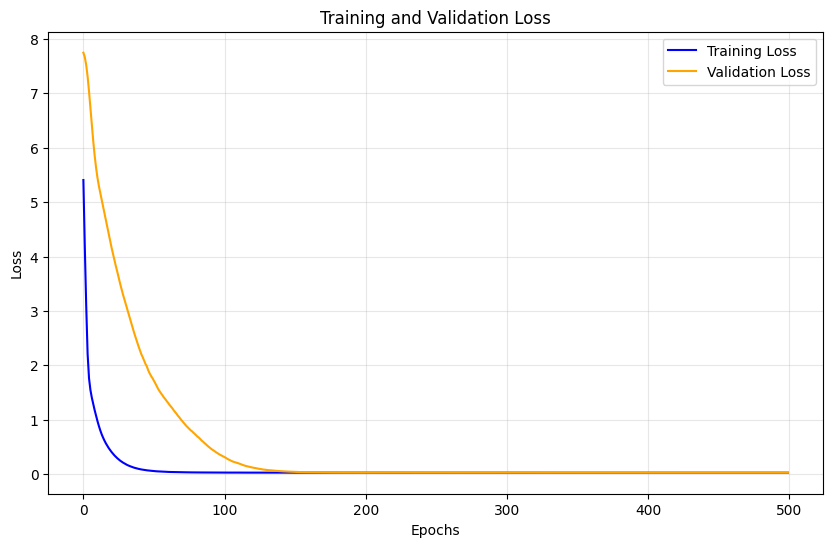

In [7]:
plot_loss(history)

# Prediction & Performance

In [2]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [3]:
test_split = 0.4  # 테스트 데이터 비율
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/sulfate/2019data/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2013.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2013/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Sulfate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2025-01-13 13:39:10.172126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-13 13:39:10.173720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22080 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-13 13:39:10.175205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22080 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-13 13:39:10.176638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21956 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

2/2 [==============================] - 2s 300ms/step


In [4]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [5]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

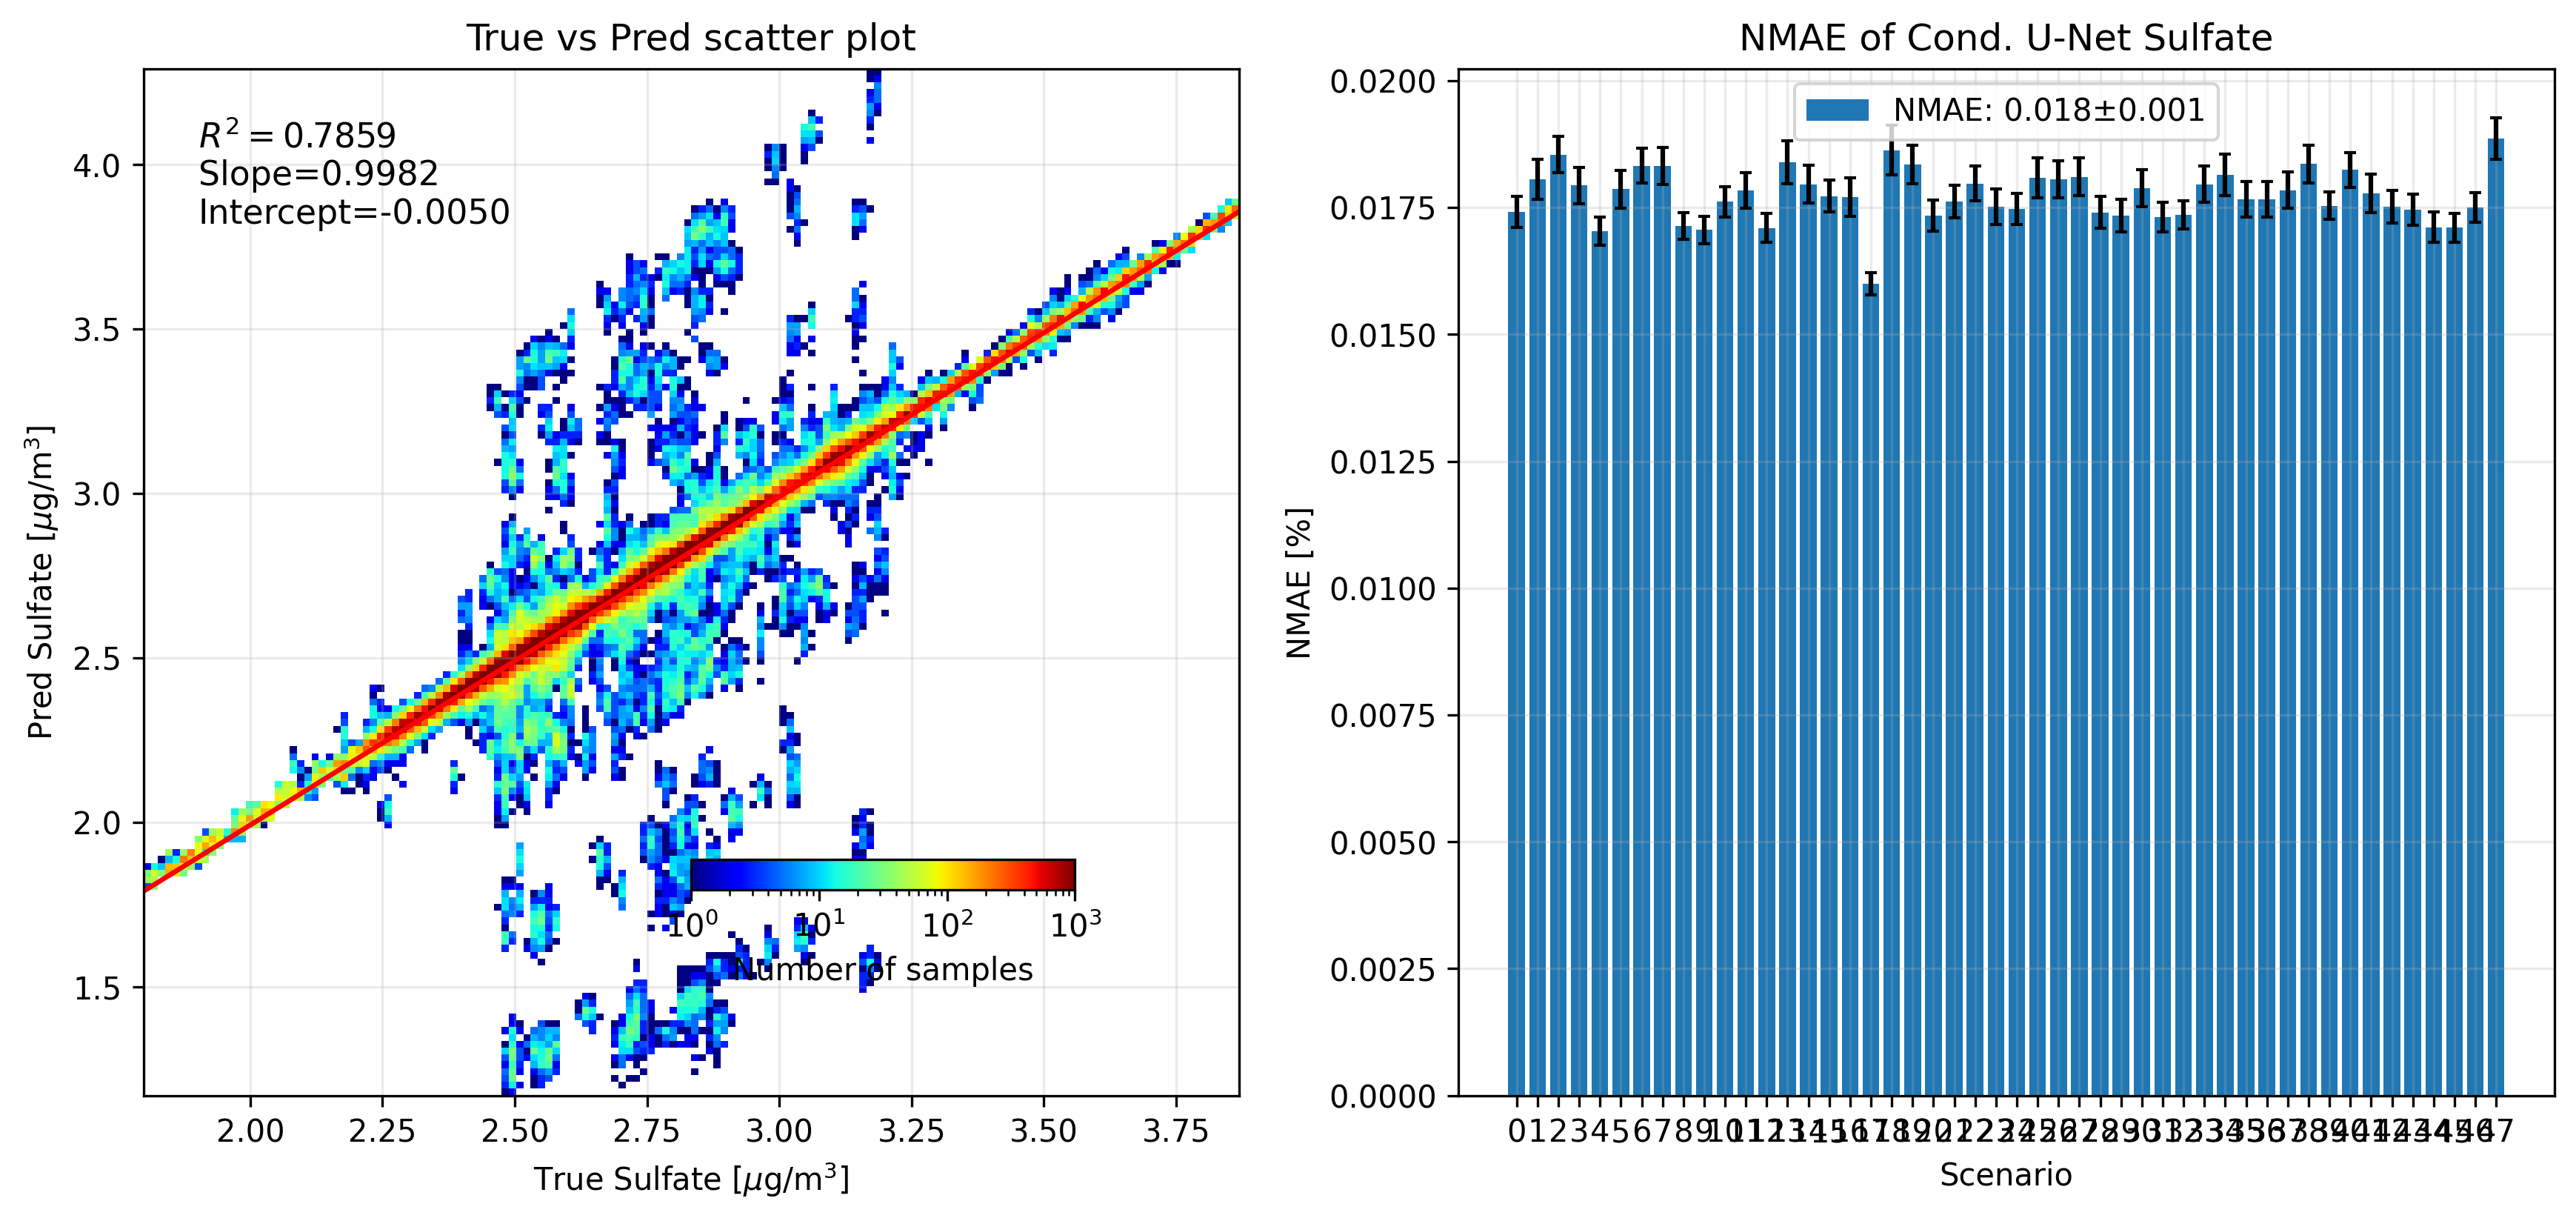

In [6]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs Pred scatter plot")
axes[0].set_xlabel('True Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Sulfate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')
plt.show()

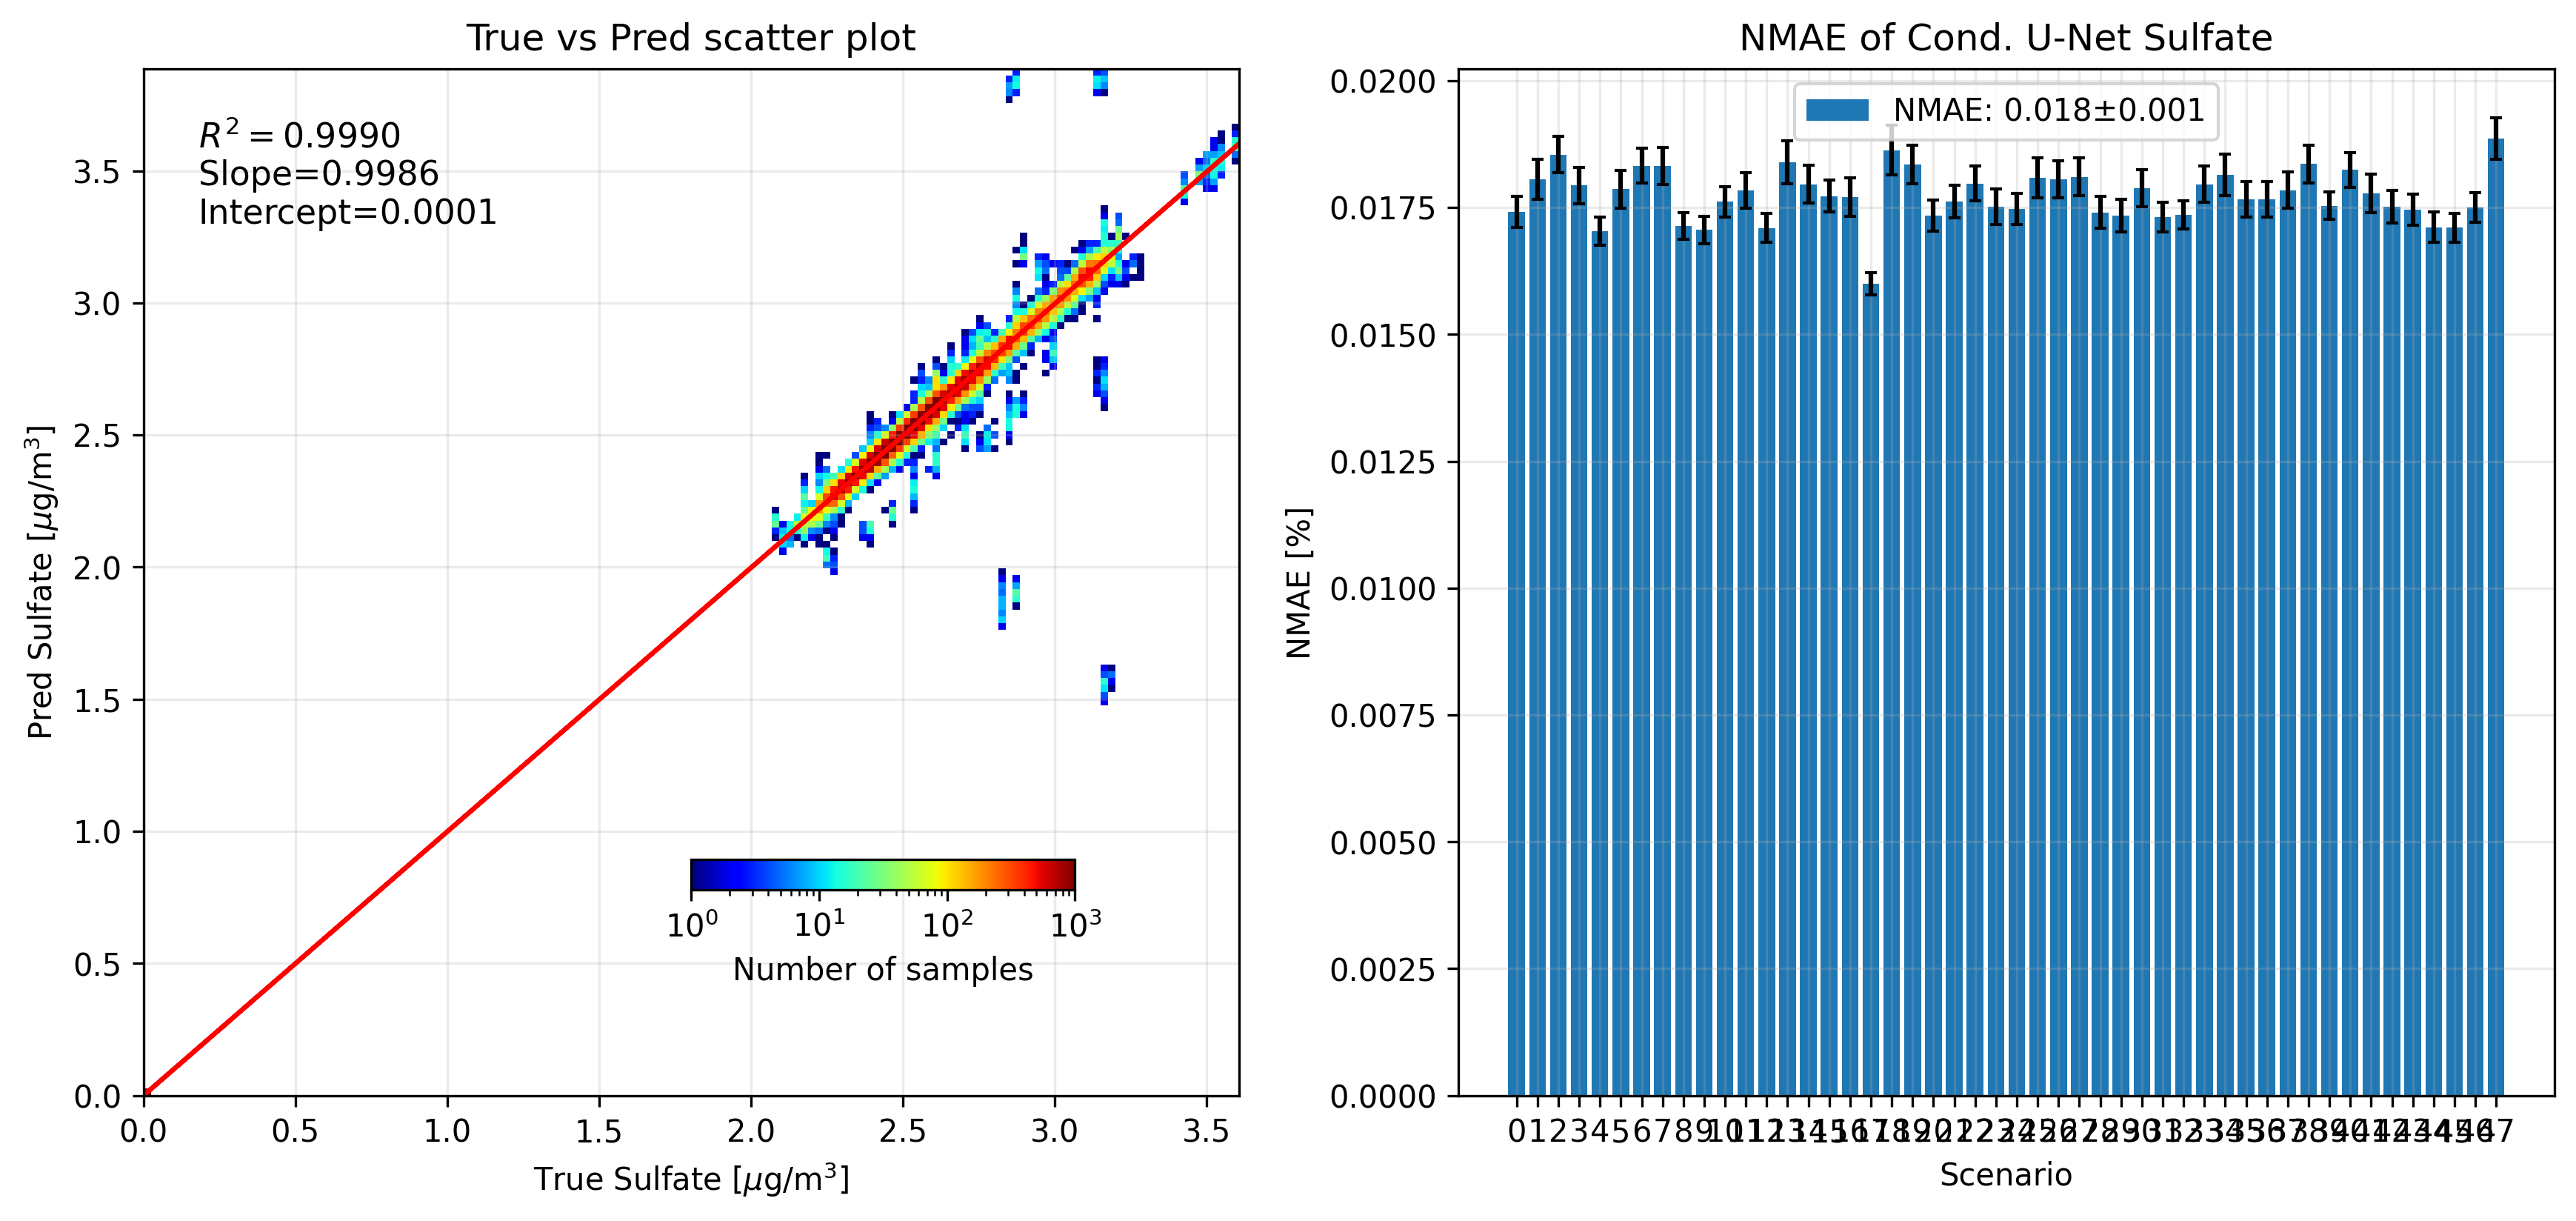

In [7]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs Pred scatter plot")
axes[0].set_xlabel('True Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Sulfate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [8]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[1]


/tmp/ipykernel_1239697/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1239697/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1239697/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1239697/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1239697/3432564490.py:62: UserWarning: set_ti

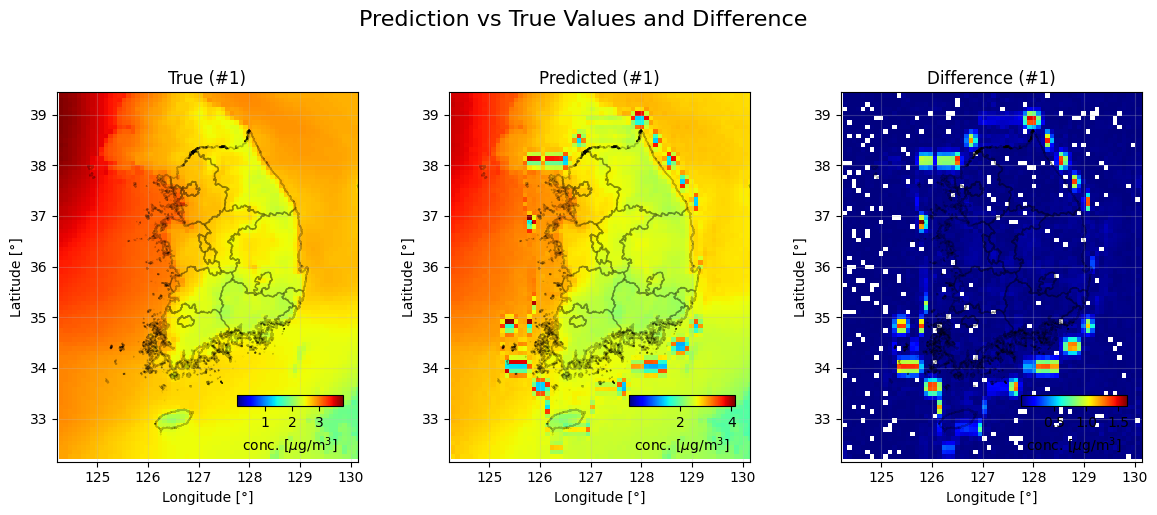

[38]


/tmp/ipykernel_1239697/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1239697/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1239697/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1239697/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1239697/3432564490.py:62: UserWarning: set_ti

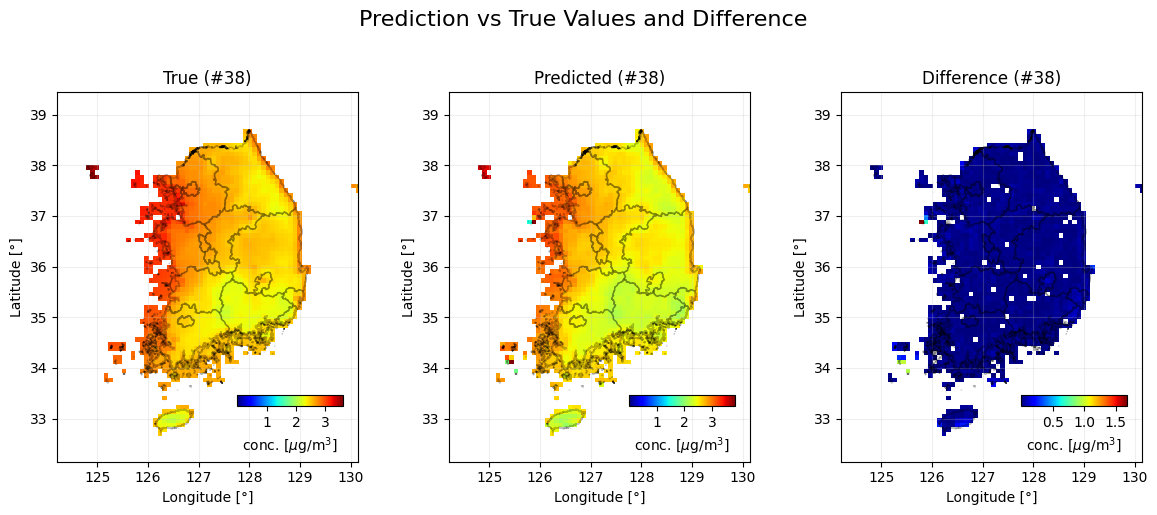

In [9]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

In [10]:
tf.keras.backend.clear_session()